In [9]:
import pandas as pd
import csv
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
import warnings
from sklearn.preprocessing import MinMaxScaler
from prettytable import PrettyTable 

warnings.filterwarnings('ignore')

# Creating the datasets

In [10]:
#getting files names
#aps
aps_directory = "E:/results ana/aps/"
aps_results_files = []
for root, dirs, files in os.walk(aps_directory):
    for name in files:
        if name.endswith((".txt")):
            aps_results_files.append(root + '/' + name)
            
#control
control_directory = "E:/results ana/control/"
control_results_files = []
for root, dirs, files in os.walk(control_directory):
    for name in files:
        if name.endswith((".txt")):
            control_results_files.append(root + '/' + name)
            
#clean unwanted files
aps_results_files.remove('E:/results ana/aps/sana7/RESULTS_FILE.txt')
control_results_files.remove('E:/results ana/control/cana9/RESULTS_FILE.txt')

aps_keys = list(pd.read_csv(aps_results_files[1],delimiter = '\t').keys())
control_keys = list(pd.read_csv(control_results_files[1],delimiter = '\t').keys())

In [11]:
aps_data = []
control_data = []

for file in aps_results_files:
    data_file = open(file, "r",encoding = 'utf-8')
    data = list(csv.reader(data_file, delimiter="\t"))[1:] #skipping header
    data_file.close()
    aps_data += data

aps_df = pd.DataFrame(aps_data, columns = aps_keys)
# set dtypes for each column
aps_df['SENTENCE_RT'] = aps_df['SENTENCE_RT'].astype(int)
aps_df['PARAPHRASE_RT'] = aps_df['PARAPHRASE_RT'].astype(float)
aps_df['condition'] = aps_df['condition'].astype(int)
aps_df['TRIAL_INDEX[2]'] = aps_df['TRIAL_INDEX[2]'].astype(int)
aps_df['group'] = 'aps'


for file in control_results_files:
    data_file = open(file, "r",encoding = 'utf-8')
    data = list(csv.reader(data_file, delimiter="\t"))[1:] #skipping header
    data_file.close()
    control_data += data

control_df = pd.DataFrame(control_data, columns = control_keys)
# set dtypes for each column
control_df['SENTENCE_RT'] = control_df['SENTENCE_RT'].astype(int)
control_df['PARAPHRASE_RT'] = control_df['PARAPHRASE_RT'].astype(float)
control_df['condition'] = control_df['condition'].astype(int)
control_df['TRIAL_INDEX[2]'] = control_df['TRIAL_INDEX[2]'].astype(int)
control_df['group'] = 'control'


#separating per block
control_df.loc[control_df['TRIAL_INDEX[2]'] <= 48, 'block'] = 1
control_df.loc[(control_df['TRIAL_INDEX[2]'] > 48) & (control_df['TRIAL_INDEX[2]'] <= 78), 'block'] = 2
control_df.loc[(control_df['TRIAL_INDEX[2]'] > 78) & (control_df['TRIAL_INDEX[2]'] <= 114), 'block'] = 3
control_df.loc[(control_df['TRIAL_INDEX[2]'] > 114), 'block'] = 4

#separating per block
aps_df.loc[aps_df['TRIAL_INDEX[2]'] <= 48, 'block'] = 1
aps_df.loc[(aps_df['TRIAL_INDEX[2]'] > 48) & (aps_df['TRIAL_INDEX[2]'] <= 78), 'block'] = 2
aps_df.loc[(aps_df['TRIAL_INDEX[2]'] > 78) & (aps_df['TRIAL_INDEX[2]'] <= 114), 'block'] = 3
aps_df.loc[(aps_df['TRIAL_INDEX[2]'] > 114), 'block'] = 4

In [12]:
aps_df.to_csv('Only_aps_data.csv', header= True, index = False, encoding='latin1')
control_df.to_csv('Only_control_data.csv', header= True, index = False, encoding='latin1')
pd.concat([aps_df,control_df]).to_csv('all_data.csv', header= True, index = False, encoding='latin1')

# APS


## Data cleaning

In [13]:
#keeping only target sentences
targets_aps_df = aps_df[aps_df.sentence_type == 'target']


#cleaning the sentence reading times for each participant in each condition
print(aps_df.SENTENCE_RT.describe())
upper_rt = 16500
lower_rt = 600

clean_aps_df = targets_aps_df[targets_aps_df.SENTENCE_RT < upper_rt]
clean_aps_df = clean_aps_df[clean_aps_df.SENTENCE_RT > lower_rt]

print( '% removed:', (1-len(clean_aps_df)/len(targets_aps_df)) * 100)

#now actually implementing the change and 
targets_aps_df.loc[targets_aps_df.SENTENCE_RT > upper_rt, 'SENTENCE_RT'] = np.nan #upper_rt
targets_aps_df.loc[targets_aps_df.SENTENCE_RT < lower_rt, 'SENTENCE_RT'] = np.nan #lower_rt

targets_aps_df = targets_aps_df.dropna(axis = 0, subset = ['SENTENCE_RT']) #remove what is out of the bounds

print(targets_aps_df.SENTENCE_RT.describe())


count     1500.000000
mean      5861.976667
std       3768.916690
min       1039.000000
25%       3375.500000
50%       4900.000000
75%       7238.500000
max      30313.000000
Name: SENTENCE_RT, dtype: float64
% removed: 3.125
count      465.000000
mean      5727.763441
std       2951.428078
min       1186.000000
25%       3520.000000
50%       5278.000000
75%       7270.000000
max      16393.000000
Name: SENTENCE_RT, dtype: float64


In [14]:
#for every subject, we want to remove the colinearity between points so we log transform the RTs and scaled
#targets_aps_df['SENTENCE_RT_log'] = np.log10(targets_aps_df['SENTENCE_RT']) #log scaling
#targets_aps_df['SENTENCE_RT_norm']  = (targets_aps_df['SENTENCE_RT_log']  - targets_aps_df['SENTENCE_RT_log'].mean()) / targets_aps_df['SENTENCE_RT_log'].std()     
  
#making sure the normalization worked
#targets_aps_df['SENTENCE_RT_norm'].describe()

In [15]:
#for each condition, RTs that were further than 2 std from the mean were removed
clean_aps_df = targets_aps_df

def bounds_calc(df, ID, cond):
    mean = df[(df.condition == cond) & (df.Session_Name_ == ID)]['SENTENCE_RT'].mean()
    std = df[(df.condition == cond) & (df.Session_Name_ == ID)]['SENTENCE_RT'].std()
    return  mean - 2*std, mean + 2*std

for ID in list(clean_aps_df.Session_Name_.unique()):
    for i in [1,2,3,4]: #clean for every condition seperately   
    
        lower,upper = bounds_calc(targets_aps_df, ID, i)
        #set to nan all the out-of-boundary trials to delete after
        clean_aps_df.loc[(clean_aps_df.Session_Name_ == ID) & (clean_aps_df.condition == i) & (clean_aps_df.SENTENCE_RT < lower), 'SENTENCE_RT'] = np.nan
        clean_aps_df.loc[(clean_aps_df.Session_Name_ == ID) & (clean_aps_df.condition == i) & (clean_aps_df.SENTENCE_RT > upper), 'SENTENCE_RT'] = np.nan

aps_final = clean_aps_df.dropna(axis = 0, subset = ['SENTENCE_RT']) #remove what is out of the bounds

print( '% removed:', (1-len(aps_final)/len(targets_aps_df)) * 100)
print( 'total % removed:', (1-len(aps_final)/len(aps_df[aps_df.sentence_type == 'target'])) * 100)

aps_final.describe()

% removed: 3.655913978494618
total % removed: 6.666666666666665


,TRIAL_INDEX[2],SENTENCE_RT,PARAPHRASE_RT,condition,block
count,448.000000,448.000000,448.000000,448.000000,448.000000
mean,77.162946,5537.102679,3270.299330,2.504464,2.439732
std,40.786318,2745.819073,1991.045896,1.115270,1.147288
min,7.000000,1186.000000,1201.090000,1.000000,1.000000
25%,41.000000,3495.500000,2024.240000,2.000000,1.000000
50%,78.500000,5133.500000,2612.245000,2.500000,2.500000
75%,112.250000,7116.750000,3957.362500,3.250000,3.000000
max,150.000000,16080.000000,24461.250000,4.000000,4.000000


## Data visualization

### All data

#### RTs

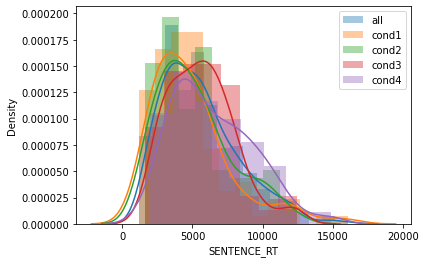

In [16]:
# Plotting with Seaborn

sns.distplot(aps_final.SENTENCE_RT, label = 'all')
sns.distplot(aps_final.loc[aps_final.condition == 1,'SENTENCE_RT'], label = 'cond1')
sns.distplot(aps_final.loc[aps_final.condition == 2,'SENTENCE_RT'], label = 'cond2')
sns.distplot(aps_final.loc[aps_final.condition == 3,'SENTENCE_RT'], label = 'cond3')
sns.distplot(aps_final.loc[aps_final.condition == 4,'SENTENCE_RT'], label = 'cond4')

plt.legend()

In [17]:
def get_means(df, y_to_plot):
    mean_cond1 = df.loc[(df.condition == 1), y_to_plot].mean()
    mean_cond2 = df.loc[(df.condition == 2), y_to_plot].mean()
    mean_cond3 = df.loc[(df.condition == 3), y_to_plot].mean()
    mean_cond4 = df.loc[(df.condition == 4), y_to_plot].mean()
    
    return mean_cond1, mean_cond2, mean_cond3, mean_cond4

def plot_means(means):
    mins = [0.05,0.3,0.55,0.8] 
    maxs = [0.2,0.45,0.7,0.95]
     
    for i,mean in enumerate(means):
        ax.axhline(mean, xmin = mins[i], xmax = maxs[i], ls='--', color = 'y')
        
    return means

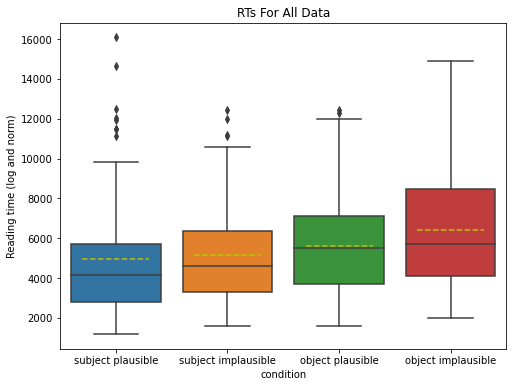

In [18]:
labels = ['subject plausible','subject implausible', 'object plausible','object implausible']
data = pd.concat([aps_final['condition'], aps_final['SENTENCE_RT']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='condition', y='SENTENCE_RT', data=data)
plot_means(get_means(aps_final,'SENTENCE_RT'))
fig.set_xticklabels(labels);
fig.set_ylabel('Reading time (log and norm)')
fig.set_title('RTs For All Data');

#### Accuracy

In [19]:
# proportion of correct answers
# for every participant, for every condition, we can compute the proportion of correct answers (correct/all)

summary_df = aps_final.drop_duplicates(subset = ['Session_Name_', 'condition', 'group', 'speech_condition','block']).loc[:,['Session_Name_', 'condition','group','speech_condition','block']]
summary_df.reset_index(drop=True, inplace=True)
    
#get the number of correct answers for each participant in each condition
for ID in list(aps_final.Session_Name_.unique()):
    for speaker in ['french', 'chinese']:
        for cond in [1,2,3,4]:
        
            corr = len(aps_final[(aps_final.PARAPHRASE_ACCURACY == '1') & (aps_final.Session_Name_ == ID) & (aps_final.condition == cond) & (aps_final.speech_condition == speaker)])
            tot  = len(aps_final[(aps_final.Session_Name_ == ID) & (aps_final.condition == cond) & (aps_final.speech_condition == speaker) ])
            summary_df.loc[(summary_df.condition == cond) & (summary_df.Session_Name_== ID) & (summary_df.speech_condition == speaker), 'PERC_CORRECT'] = corr/tot
        
aps_summary = summary_df

Text(0.5, 1.0, 'Paraphrase Accuracy')

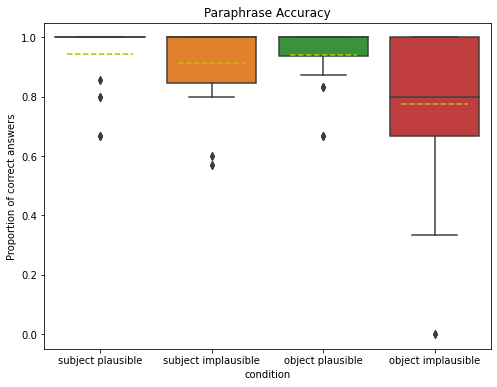

In [639]:
labels = ['subject plausible','subject implausible', 'object plausible','object implausible']
data = pd.concat([summary_df['condition'], summary_df['PERC_CORRECT']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='condition', y='PERC_CORRECT', data=data)
fig.set_xticklabels(labels);
plot_means(get_means(summary_df,'PERC_CORRECT'))
fig.set_ylabel('Proportion of correct answers')
fig.set_title('Paraphrase Accuracy')

### Only correct answers

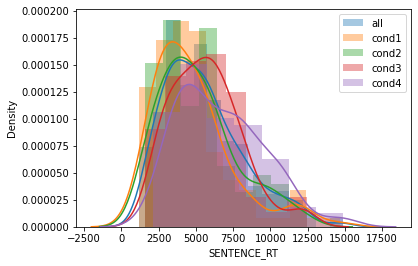

In [640]:
#keeping only target sentences that have accurate paraphrase answer
correct_aps_final = aps_final[aps_final.PARAPHRASE_ACCURACY == '1']

sns.distplot(correct_aps_final.SENTENCE_RT, label = 'all')
sns.distplot(correct_aps_final.loc[correct_aps_final.condition == 1,'SENTENCE_RT'], label = 'cond1')
sns.distplot(correct_aps_final.loc[correct_aps_final.condition == 2,'SENTENCE_RT'], label = 'cond2')
sns.distplot(correct_aps_final.loc[correct_aps_final.condition == 3,'SENTENCE_RT'], label = 'cond3')
sns.distplot(correct_aps_final.loc[correct_aps_final.condition == 4,'SENTENCE_RT'], label = 'cond4')

plt.legend()

Text(0.5, 1.0, 'Normalized RTs For Correct Answers Only')

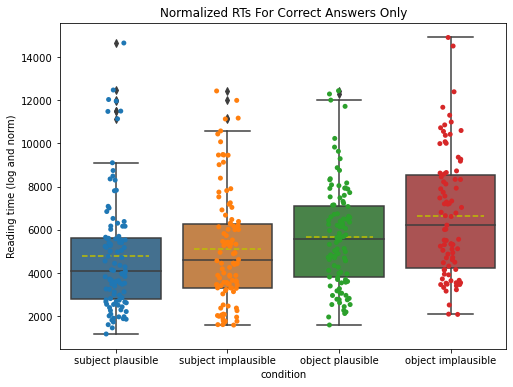

In [641]:
labels = ['subject plausible','subject implausible', 'object plausible','object implausible']
data = pd.concat([correct_aps_final['condition'], correct_aps_final['SENTENCE_RT']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='condition', y='SENTENCE_RT', data=data, saturation = 0.5)
sns.stripplot(x='condition', y='SENTENCE_RT', data=data,dodge=True, ax=ax)
plot_means(get_means(correct_aps_final,'SENTENCE_RT'))
fig.set_xticklabels(labels);
fig.set_ylabel('Reading time (log and norm)')
fig.set_title('Normalized RTs For Correct Answers Only')

In [642]:
correct_aps_final.to_csv('Preprocessed_aps_data.csv', header= True, index = False, encoding='latin1')

# Control

## Data Cleaning


In [643]:
#keeping only target sentences
targets_control_df = control_df[control_df.sentence_type == 'target']

#cleaning the sentence reading times for each participant in each condition
print(control_df.SENTENCE_RT.describe())
upper_rt = 16500
lower_rt = 600

clean_control_df = targets_control_df[targets_control_df.SENTENCE_RT < upper_rt]
clean_control_df = clean_control_df[clean_control_df.SENTENCE_RT > lower_rt]

print( '% removed:', (1-len(clean_control_df)/len(targets_control_df)) * 100)

#now actually implementing the change and 
targets_control_df.loc[targets_control_df.SENTENCE_RT > upper_rt, 'SENTENCE_RT'] = np.nan #upper_rt
targets_control_df.loc[targets_control_df.SENTENCE_RT < lower_rt, 'SENTENCE_RT'] = np.nan #lower_rt

targets_control_df = targets_control_df.dropna(axis = 0, subset = ['SENTENCE_RT']) #remove what is out of the bounds

#print(targets_control_df.SENTENCE_RT.describe())


count     1559.000000
mean      6582.984606
std       4647.700587
min         67.000000
25%       3549.500000
50%       5172.000000
75%       8076.500000
max      38296.000000
Name: SENTENCE_RT, dtype: float64
% removed: 5.010020040080166


In [644]:
#for each condition, RTs that were further than 2 std from the mean were removed
clean_control_df = targets_control_df

for ID in list(clean_control_df.Session_Name_.unique()):
    for i in [1,2,3,4]: #clean for every condition seperately   
    
        lower,upper = bounds_calc(targets_control_df, ID, i)
        #set to nan all the out-of-boundary trials to delete after
        clean_control_df.loc[(clean_control_df.Session_Name_ == ID) & (clean_control_df.condition == i) & (clean_control_df.SENTENCE_RT < lower), 'SENTENCE_RT'] = np.nan
        clean_control_df.loc[(clean_control_df.Session_Name_ == ID) & (clean_control_df.condition == i) & (clean_control_df.SENTENCE_RT > upper), 'SENTENCE_RT'] = np.nan
    
control_final = clean_control_df.dropna(axis = 0, subset = ['SENTENCE_RT']) #remove what is out of the bounds

print( '% removed:', (1-len(control_final)/len(targets_control_df)) * 100)
print( 'total % removed:', (1-len(control_final)/len(control_df[control_df.sentence_type == 'target'])) * 100)

% removed: 4.641350210970463
total % removed: 9.4188376753507


## Data Visualization

### All Data

#### RTs

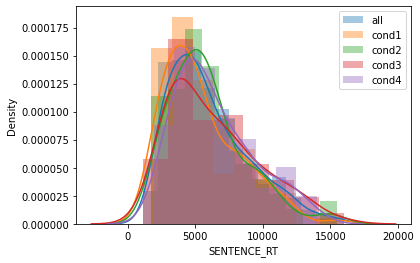

In [645]:
# Plotting with Seaborn

sns.distplot(control_final.SENTENCE_RT, label = 'all')
sns.distplot(control_final.loc[control_final.condition == 1,'SENTENCE_RT'], label = 'cond1')
sns.distplot(control_final.loc[control_final.condition == 2,'SENTENCE_RT'], label = 'cond2')
sns.distplot(control_final.loc[control_final.condition == 3,'SENTENCE_RT'], label = 'cond3')
sns.distplot(control_final.loc[control_final.condition == 4,'SENTENCE_RT'], label = 'cond4')

plt.legend()

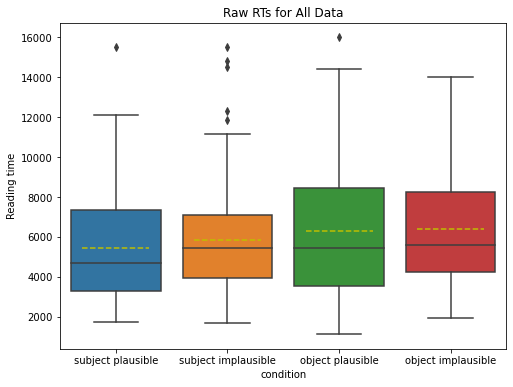

In [646]:
labels = ['subject plausible','subject implausible', 'object plausible','object implausible']
data = pd.concat([control_final['condition'], control_final['SENTENCE_RT']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='condition', y='SENTENCE_RT', data=data)
fig.set_xticklabels(labels);
plot_means(get_means(control_final, 'SENTENCE_RT'))
fig.set_ylabel('Reading time');
fig.set_title('Raw RTs for All Data');

#### Accuracy

In [647]:
# proportion of correct answers
# for every participant, for every condition, we can compute the proportion of correct answers (correct/all)

summary_df = control_final.drop_duplicates(subset =
                                           ['Session_Name_', 'condition','group','block']).loc[:,['Session_Name_', 'condition','group','block']]
summary_df.reset_index(drop=True, inplace=True)
    
#get the number of correct answers for each participant in each condition
for ID in list(control_final.Session_Name_.unique()):
    if ID == 'cana1':
        for cond in [1,2]:
            corr = len(control_final[(control_final.PARAPHRASE_ACCURACY == '1') & (control_final.Session_Name_ == ID) & (control_final.condition == cond)])
            tot  = len(control_final[(control_final.Session_Name_ == ID) & (control_final.condition == cond) ])
            
            summary_df.loc[(summary_df.condition == cond) & (summary_df.Session_Name_== ID), 'PERC_CORRECT'] = corr/tot
            
    elif ID != 'cana1':
        for cond in [1,2,3,4]:
            corr = len(control_final[(control_final.PARAPHRASE_ACCURACY == '1') & (control_final.Session_Name_ == ID) & (control_final.condition == cond)])
            tot  = len(control_final[(control_final.Session_Name_ == ID) & (control_final.condition == cond) ])
               
            summary_df.loc[(summary_df.condition == cond) & (summary_df.Session_Name_== ID), 'PERC_CORRECT'] = corr/tot
control_summary = summary_df

Text(0.5, 1.0, 'Paraphrase Accurary')

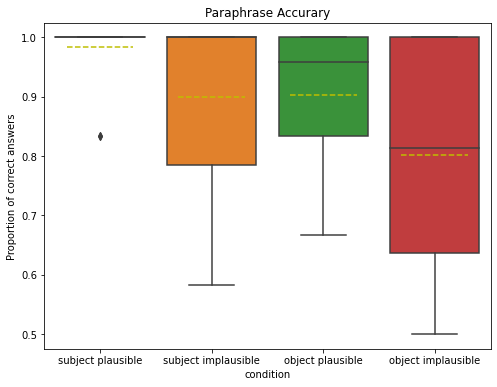

In [648]:
labels = ['subject plausible','subject implausible', 'object plausible','object implausible']
data = pd.concat([summary_df['condition'], summary_df['PERC_CORRECT']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='condition', y='PERC_CORRECT', data=data)
fig.set_xticklabels(labels);
plot_means(get_means(control_summary, 'PERC_CORRECT'))
fig.set_ylabel('Proportion of correct answers')
fig.set_title('Paraphrase Accurary')

## RTs Correct Answers Only

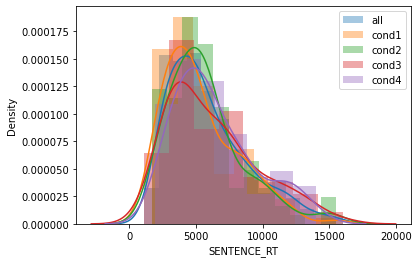

In [649]:
#keeping only target sentences that have accurate paraphrase answer
correct_control_final = control_final[control_final.PARAPHRASE_ACCURACY == '1']

sns.distplot(correct_control_final.SENTENCE_RT, label = 'all')
sns.distplot(correct_control_final.loc[correct_control_final.condition == 1,'SENTENCE_RT'], label = 'cond1')
sns.distplot(correct_control_final.loc[correct_control_final.condition == 2,'SENTENCE_RT'], label = 'cond2')
sns.distplot(correct_control_final.loc[correct_control_final.condition == 3,'SENTENCE_RT'], label = 'cond3')
sns.distplot(correct_control_final.loc[correct_control_final.condition == 4,'SENTENCE_RT'], label = 'cond4')

plt.legend()

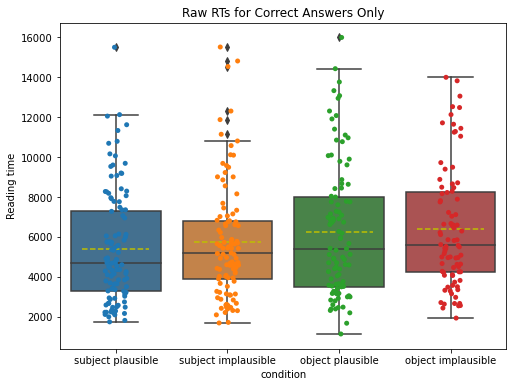

In [650]:
labels = ['subject plausible','subject implausible', 'object plausible','object implausible']
data = pd.concat([correct_control_final['condition'], correct_control_final['SENTENCE_RT']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='condition', y='SENTENCE_RT', data=data, saturation = 0.5)
sns.stripplot(x='condition', y='SENTENCE_RT', data=data,dodge=True, ax=ax)
fig.set_xticklabels(labels);
plot_means(get_means(correct_control_final, 'SENTENCE_RT'))
fig.set_ylabel('Reading time');
fig.set_title('Raw RTs for Correct Answers Only');

In [651]:
correct_control_final.to_csv('Preprocessed_control_data.csv', header= True, index = False, encoding='latin1')

# Comparing control to APS

In [652]:
#putting all together
all_final = pd.concat([aps_final, control_final])
all_correct_final = pd.concat([correct_aps_final, correct_control_final])
summary_dfs = pd.concat([aps_summary, control_summary])

In [653]:
all_final.to_csv('all_groups_data.csv', header= True, index = False, encoding='latin1')

## ALL RTs
`

In [654]:
def get_means2(df, y_to_plot, group):
    mean_cond1 = df.loc[(df.condition == 1) & (df.group == group), y_to_plot].mean()
    mean_cond2 = df.loc[(df.condition == 2) & (df.group == group), y_to_plot].mean()
    mean_cond3 = df.loc[(df.condition == 3) & (df.group == group), y_to_plot].mean()
    mean_cond4 = df.loc[(df.condition == 4) & (df.group == group), y_to_plot].mean()
    
    return mean_cond1, mean_cond2, mean_cond3, mean_cond4

def plot_means2(means, group):
    if group == 'aps':
        mins = [0.05,0.3,0.55,0.8] 
        maxs = [0.12,0.36,0.62,0.86]
    elif group == 'control':
        mins = [0.14,0.40,0.64,0.90]
        maxs = [0.22,0.46,0.70,0.96] 
     
    for i,mean in enumerate(means):
        ax.axhline(mean, xmin = mins[i], xmax = maxs[i], ls='--', color = 'r')
        
    return means

Text(0.5, 1.0, 'RTs For All answers')

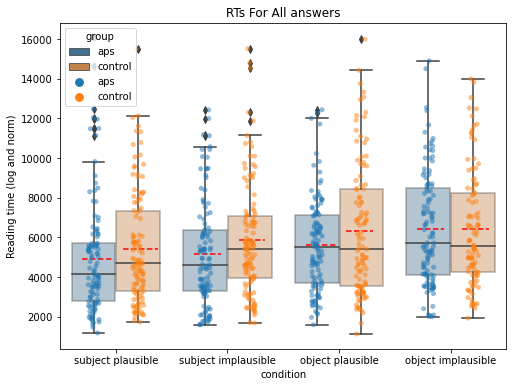

In [655]:
all_final = pd.concat([aps_final, control_final])

labels = ['subject plausible','subject implausible', 'object plausible','object implausible']
data = all_final
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='condition', y='SENTENCE_RT', hue="group",  data=data, saturation = 0.5, boxprops={'alpha': 0.4})
sns.stripplot(x='condition', y='SENTENCE_RT', hue = "group", data=data, dodge=True, ax=ax, alpha = 0.5)
plot_means2(get_means2(data, 'SENTENCE_RT', 'aps'), 'aps')
plot_means2(get_means2(data, 'SENTENCE_RT', 'control'), 'control')
fig.set_xticklabels(labels);
fig.set_ylabel('Reading time (log and norm)')
fig.set_title('RTs For All answers')

## ALL RTs ONLY FOR CORRECT ANSWERS

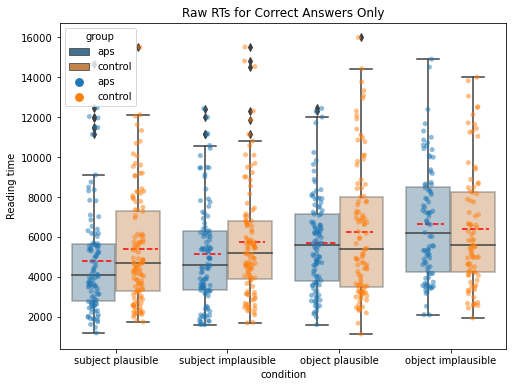

In [656]:
labels = ['subject plausible','subject implausible', 'object plausible','object implausible']
data = all_correct_final
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='condition', y='SENTENCE_RT', data=data, saturation = 0.5, hue= 'group', boxprops={'alpha': 0.4})
sns.stripplot(x='condition', y='SENTENCE_RT', data=data,dodge=True, ax=ax, hue = 'group', alpha = 0.5)
plot_means2(get_means2(data, 'SENTENCE_RT', 'aps'), 'aps')
plot_means2(get_means2(data, 'SENTENCE_RT', 'control'), 'control')
fig.set_xticklabels(labels);
fig.set_ylabel('Reading time');
fig.set_title('Raw RTs for Correct Answers Only');

Text(0.5, 1.0, 'Paraphrase Accuracy')

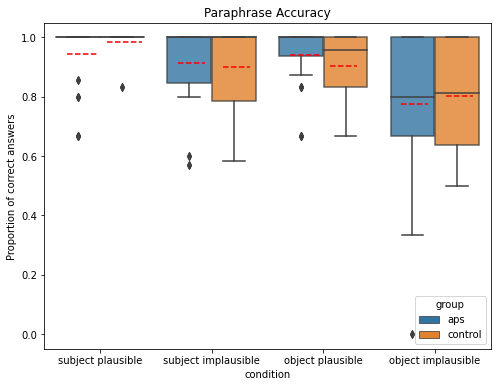

In [657]:
labels = ['subject plausible','subject implausible', 'object plausible','object implausible']
data = summary_dfs
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='condition', y='PERC_CORRECT', data=data, hue = 'group', boxprops={'alpha': 0.8})
fig.set_xticklabels(labels);
plot_means2(get_means2(data, 'PERC_CORRECT', 'aps'), 'aps')
plot_means2(get_means2(data, 'PERC_CORRECT', 'control'), 'control')
fig.set_ylabel('Proportion of correct answers')
fig.set_title('Paraphrase Accuracy')

# Nice table

In [668]:
# Specify the Column Names while initializing the Table 
 
# Add rows 

def produce_table1(block = 0):
    myTable = PrettyTable(["Speaker", "Structure", "RT - Plausible", "RT - Implausible", "AC - Plausible", "AC -Implausible"]) 
    
    if block == 0:
        
        control_final = all_correct_final[(all_correct_final.group == 'control')]
        control_summary = summary_dfs[(summary_dfs.group == 'control')]
    
        aps_final = all_correct_final[(all_correct_final.group == 'aps')]
        aps_summary = summary_dfs[(summary_dfs.group == 'aps')]
    
    elif block in [1,2,3,4]:
        control_final = all_correct_final[(all_correct_final.block == block) & (all_correct_final.group == 'control')]
        control_summary = summary_dfs[(summary_dfs.block == block) & (summary_dfs.group == 'control')]
    
        aps_final = all_correct_final[(all_correct_final.block == block) & (all_correct_final.group == 'aps')]
        aps_summary = summary_dfs[(summary_dfs.block == block) & (summary_dfs.group == 'aps')]
    

    
    #control
    myTable.add_row(["No APS", "SRC", round(control_final.loc[control_final.condition == 1,'SENTENCE_RT'].mean()),
                                      round(control_final.loc[control_final.condition == 2,'SENTENCE_RT'].mean()),
                                      round(control_summary.loc[control_summary.condition == 1 ,'PERC_CORRECT'].mean(),2),
                                      round(control_summary.loc[control_summary.condition == 2 ,'PERC_CORRECT'].mean(),2) ])

    myTable.add_row([" ", "ORC", round(control_final.loc[control_final.condition == 3 ,'SENTENCE_RT'].mean()),
                                      round(control_final.loc[control_final.condition == 4 ,'SENTENCE_RT'].mean()),
                                      round(control_summary.loc[control_summary.condition == 3 ,'PERC_CORRECT'].mean(),2),
                                      round(control_summary.loc[control_summary.condition == 4 ,'PERC_CORRECT'].mean(),2) ])


    myTable.add_row([ " " , " " ," " " "," "," ", " "])

    #aps

    myTable.add_row(["APS - FRENCH", "SRC", round(aps_final.loc[(aps_final.condition == 1) & (aps_final.speech_condition == 'french'),'SENTENCE_RT'].mean()),
                                      round(aps_final.loc[(aps_final.condition == 2) & (aps_final.speech_condition == 'french'),'SENTENCE_RT'].mean()),
                                      round(aps_summary.loc[(aps_summary.condition == 1) & (aps_summary.speech_condition == 'french') ,'PERC_CORRECT'].mean(),2),
                                      round(aps_summary.loc[(aps_summary.condition == 2) & (aps_summary.speech_condition == 'french') ,'PERC_CORRECT'].mean(),2) ])

    myTable.add_row([" ", "ORC", round(aps_final.loc[(aps_final.condition == 3) & (aps_final.speech_condition == 'french'),'SENTENCE_RT'].mean()),
                                 round(aps_final.loc[(aps_final.condition == 4) & (aps_final.speech_condition == 'french'),'SENTENCE_RT'].mean()),
                                 round(aps_summary.loc[(aps_summary.condition == 3) & (aps_summary.speech_condition == 'french') ,'PERC_CORRECT'].mean(),2),
                                 round(aps_summary.loc[(aps_summary.condition == 4) & (aps_summary.speech_condition == 'french') ,'PERC_CORRECT'].mean(),2) ])

    myTable.add_row([ " " , " " ," " " "," "," ", " "])

    #aps

    myTable.add_row(["APS - CHINESE", "SRC", round(aps_final.loc[(aps_final.condition == 1) & (aps_final.speech_condition == 'chinese'),'SENTENCE_RT'].mean()),
                                      round(aps_final.loc[(aps_final.condition == 2) & (aps_final.speech_condition == 'chinese'),'SENTENCE_RT'].mean()),
                                      round(aps_summary.loc[(aps_summary.condition == 1) & (aps_summary.speech_condition == 'chinese') ,'PERC_CORRECT'].mean(),2),
                                      round(aps_summary.loc[(aps_summary.condition == 2) & (aps_summary.speech_condition == 'chinese') ,'PERC_CORRECT'].mean(),2) ])

    myTable.add_row([" ", "ORC", round(aps_final.loc[(aps_final.condition == 3) & (aps_final.speech_condition == 'chinese'),'SENTENCE_RT'].mean()),
                                 round(aps_final.loc[(aps_final.condition == 4) & (aps_final.speech_condition == 'chinese'),'SENTENCE_RT'].mean()),
                                 round(aps_summary.loc[(aps_summary.condition == 3) & (aps_summary.speech_condition == 'chinese') ,'PERC_CORRECT'].mean(),2),
                                 round(aps_summary.loc[(aps_summary.condition == 4) & (aps_summary.speech_condition == 'chinese') ,'PERC_CORRECT'].mean(),2) ])
    
    
    #all_aps

    myTable.add_row(["APS - ALL", "SRC", round(aps_final.loc[(aps_final.condition == 1) ,'SENTENCE_RT'].mean()),
                                      round(aps_final.loc[(aps_final.condition == 2), 'SENTENCE_RT'].mean()),
                                      round(aps_summary.loc[(aps_summary.condition == 1), 'PERC_CORRECT'].mean(),2),
                                      round(aps_summary.loc[(aps_summary.condition == 2),'PERC_CORRECT'].mean(),2) ])

    myTable.add_row([" ", "ORC", round(aps_final.loc[(aps_final.condition == 3),'SENTENCE_RT'].mean()),
                                 round(aps_final.loc[(aps_final.condition == 4),'SENTENCE_RT'].mean()),
                                 round(aps_summary.loc[(aps_summary.condition == 3)  ,'PERC_CORRECT'].mean(),2),
                                 round(aps_summary.loc[(aps_summary.condition == 4)  ,'PERC_CORRECT'].mean(),2) ])


    print(myTable)


In [669]:
produce_table1()
produce_table1(1)
produce_table1(2)
produce_table1(3)
produce_table1(4)

+---------------+-----------+----------------+------------------+----------------+-----------------+
|    Speaker    | Structure | RT - Plausible | RT - Implausible | AC - Plausible | AC -Implausible |
+---------------+-----------+----------------+------------------+----------------+-----------------+
|     No APS    |    SRC    |      5389      |       5729       |      0.98      |       0.9       |
|               |    ORC    |      6238      |       6392       |      0.9       |       0.8       |
|               |           |                |                  |                |                 |
|  APS - FRENCH |    SRC    |      4894      |       4977       |      0.97      |       0.91      |
|               |    ORC    |      5500      |       6273       |      0.94      |       0.76      |
|               |           |                |                  |                |                 |
| APS - CHINESE |    SRC    |      4707      |       5270       |      0.92      |       0.